## Script's Goals

This script is designed to reproduce the integration and pre-processing steps performed on a single-cell dataset. To achieve this, a preprocessed dataset (referred to as the "targeted dataset") is analyzed to understand the steps involved in pre-processing single-cell data, and then these steps are applied from scratch to raw data.

The raw data come from two samples in the standard 10x Genomics format (barcodes.tsv.gz, features.tsv.gz, and matrix.tsv.gz). These data will be integrated into an AnnData object and then pre-processed using the Scanpy module to produce a preprocessed object that corresponds to the targeted dataset.

 ## Import packages

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
from scipy.sparse import issparse
import os
import gzip
import scipy.io
from scipy.sparse import csr_matrix
import mygene
from pybiomart import Dataset

## Define Function

In [77]:
def tsv_to_adata(path, sample, dataset):
    # function to load files from the standard 10x Genomics format. barcodes.tsv.gz, features.tsv.gz, and matrix.tsv.gz will
    # be get in their directory to be put in a anndata object
    
    # Load the sample
    # Identify files by samples
    barcode_file = os.path.join(path, f"{sample}_barcodes.tsv.gz")
    features_file = os.path.join(path, f"{sample}_features.tsv.gz")
    matrix_file = os.path.join(path, f"{sample}_matrix.mtx.gz")

    
    # Load barcodes
    with gzip.open(barcode_file, 'rt') as f:
        barcodes = pd.read_csv(f, header=None, sep="\t")
    
    # Load features (genes)
    with gzip.open(features_file, 'rt') as f:
        features = pd.read_csv(f, header=None, sep="\t")
    
    # Load expression matrix
    with gzip.open(matrix_file, 'rt') as f:
        matrix = scipy.io.mmread(f).tocsr()
        matrix = matrix.transpose()
    
    # Create an anndata object
    adata = ad.AnnData(X=matrix)
    adata.var['gene_symbols'] = features.iloc[:, 0].values #stock genes names
    adata.obs['barcodes'] = barcodes.iloc[:, 0].values #stock barcode in obs
    adata.obs_names = adata.obs['barcodes']  #name rows as barcodes
    adata.var_names = adata.var['gene_symbols'] #name columns as genes
    
    # Add sample-specific metadata
    adata.obs['sample_id'] = sample

    # Add dataset identifiers
    adata.obs['dataset'] = dataset
    
    # Quality control
    sc.pp.filter_cells(adata, min_genes=500) #Filters out cells from the dataset that have fewer than 500 detected genes (non-zero entries)
    sc.pp.filter_genes(adata, min_cells=10) #Filters out genes from the dataset that are detected in fewer than 10 cells.
    sc.pp.filter_genes(adata, max_cells=60000) #Filters out genes from the dataset that are detected in more than 60000 cells.
    
    return adata

In [78]:
def generate_obs(adata):
    #function to calculate and pre_process data and then stock the results in adata.obs
    
    # Compute the number of genes expressed per cell
    adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(axis=1)

    # Compute the total counts per cell
    adata.obs['total_counts'] = adata.X.sum(axis=1)
    
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    
    #Compute the percentage of mitochondrial, ribosomal and hemoglobin genes in each cells
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
    )
    
    # Define cells considered as outliers based on their percentage of mitochondrial genes or total counts
    adata.obs['mt_outlier'] = adata.obs['pct_counts_mt'] > 20  # Example threshold for mitochondrial genes
    adata.obs['outlier'] = adata.obs['total_counts'] < 1000
    
    # Saving count data
    adata.layers["counts"] = adata.X.copy()
    
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    
    # Saving normalized data
    adata.layers["log1p_norm"] = adata.X.copy()
    
    # High variable genes
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample_id")
    
    # PCA
    sc.tl.pca(adata)
    
    #Nearest neighbors and visualisation with umap
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    
    # Leiden clustering
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
    
    return

In [79]:
def sum_row(df):
    # function to calculate the sum of each row of a dataframe
    row_sums = df.sum(axis=1)
    return row_sums

In [80]:
def sum_col(df):
    # function to calculate the sum of each column of a dataframe
    row_col = df.sum(axis=0)
    return row_col

In [81]:
def mean_expression(df):
    # function to calculate the mean expression of genes in a NumPy array
    mean = df.mean()  
    return mean

In [82]:
def distribution(series, name_x, name_df, log_transform=False):
    """
    Function to plot the distribution of a series with an optional log transformation.

    Args:
    - series (pd.Series or np.ndarray): The data series to plot.
    - name_x (str): The label for the x-axis.
    - name_df (str): The name of the dataframe for the plot title.
    - log_transform (bool): Whether to apply a log transformation to the series.
    """
    if log_transform:
        series = np.log1p(series)  # Apply log1p transformation
    
    plt.figure(figsize=(10, 6))
    sns.histplot(series, bins=50, kde=False)
    plt.xlabel(name_x)
    plt.ylabel('Frequency')
    title = f'Distribution of {name_x} in the dataframe {name_df}'
    if log_transform:
        title += ' (Log Transformed)'
    plt.title(title)
    plt.show()
    return

# Explore data

## Load the data

In [83]:
# Load the targeted anndata object to analyze it
PP_data = ad.read_h5ad("/home/mc202900/datasets_epigene/GSE227828.h5ad")

In [84]:
# Load the raw data to analyse them

# First sample
adata1 = tsv_to_adata("/home/mc202900/datasets_epigene/raw_data", "GSM7109167_PT1", "GSE227828")

# Second sample
adata2 = tsv_to_adata("/home/mc202900/datasets_epigene/raw_data", "GSM7109168_PT5", "GSE227828")

# Combine samples
adata = adata1.concatenate(adata2, batch_key="batch", batch_categories=["GSM7109167_PT1", "GSM7109168_PT5"])

/tmp/ipykernel_234628/4195230346.py:10: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata1.concatenate(adata2, batch_key="batch", batch_categories=["GSM7109167_PT1", "GSM7109168_PT5"])


### Replace columns names to match the targeted dataframe : change ensembl gene id to gene symbols

In [85]:
# Function to split a list into sublists to save memory for ensembl requests
def chunk_list(lst, n):
    """Splits lst into sublists with a maximum size of n."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Load the Ensembl dataset
dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')

# List of Ensembl IDs
ensembl_ids = adata.var_names.tolist()

# Split into sublists to save memory
chunk_size = 100
ensembl_chunks = list(chunk_list(ensembl_ids, chunk_size))

# Retrieve gene names for each batch
all_results = []
for chunk in ensembl_chunks:
    try:
        results = dataset.query(
            attributes=['ensembl_gene_id', 'external_gene_name'],
            filters={'link_ensembl_gene_id': chunk}
        )
        all_results.append(results)
    except Exception as e:
        print(f"Error with batch: {chunk[:5]}... -> {e}")

# Combine all results into a single DataFrame
final_results = pd.concat(all_results, ignore_index=True)

# Build a mapping (dictionary) from Ensembl IDs to gene names
gene_mapping = dict(zip(final_results['Gene stable ID'], final_results['Gene name']))

# Replace names in adata
adata.var['gene_name'] = adata.var_names.map(gene_mapping)

# Replace NaN values with original gene names using a Series
adata.var['gene_name'].fillna(pd.Series(adata.var_names), inplace=True)

# Update var_names with the new gene names
adata.var_names = adata.var['gene_name']


/tmp/ipykernel_234628/2806909899.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.var['gene_name'].fillna(pd.Series(adata.var_names), inplace=True)


In [86]:
print(adata.var_names)

Index([        nan,         nan, 'LINC01409', 'LINC01128', 'LINC00115',
           'NOC2L',    'KLHL17',   'PLEKHN1',      'HES4',     'ISG15',
       ...
          'MT-CO3',    'MT-ND3',   'MT-ND4L',    'MT-ND4',    'MT-ND5',
          'MT-ND6',    'MT-CYB',         nan,         nan,         nan],
      dtype='object', name='gene_name', length=15579)


### Get the same columns in PP_data and adata to obtain 2 comparables dataframes

In [87]:
# ---- Filtering adata columns based on matches with PP_data ---- #

pp_gene_names = PP_data.var_names.tolist()  # Gene names in PP_data

# Filter columns in adata to keep only genes present in PP_data
common_genes = adata.var['gene_name'][adata.var['gene_name'].isin(pp_gene_names)]

# Filter adata and PP_data to retain only columns corresponding to these genes
adata = adata[:, adata.var['gene_name'].isin(common_genes)].copy()

adata.var_names_make_unique

PP_data = PP_data[:, PP_data.var_names.isin(common_genes)].copy()

# Final check
print(f"Number of common genes retained: {len(common_genes)}")


Number of common genes retained: 12264


In [88]:
# Generate the obs (calculate and pre-process data)
generate_obs(adata)

## Structure of the data

### Structure of the targeted anndata object

In [89]:
print(PP_data)

AnnData object with n_obs × n_vars = 10002 × 12264
    obs: 'dataset', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'size_factors', 'leiden_res_1'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'leiden_res_1', 'log1p', 'neighbors', 'pca', 'pct_counts_mt', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'


In [90]:
print(PP_data.var_names)

Index(['LINC01409', 'LINC01128', 'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1',
       'HES4', 'ISG15', 'C1orf159', 'TNFRSF18',
       ...
       'PRKY', 'USP9Y', 'DDX3Y', 'UTY', 'TMSB4Y', 'NLGN4Y', 'TTTY14', 'KDM5D',
       'TTTY10', 'EIF1AY'],
      dtype='object', length=12264)


In [91]:
print(PP_data.obs_names)

Index(['GSM7109167_GGTCTGGGCTATCCTCC', 'GSM7109167_ATGATCGCGATACAGAA',
       'GSM7109167_GTTGTAGTACAAGCCTA', 'GSM7109167_TCCTCGAGCTTATCCAG',
       'GSM7109167_GAGTTTGGCTATCCCTC', 'GSM7109167_GGGTGTCGCTACTGGTT',
       'GSM7109167_CTCCCAAGCTGTCAGTT', 'GSM7109167_TCTTAGTTACTAGTCAG',
       'GSM7109167_CAGGCCACGAGGTGTTT', 'GSM7109167_GCTTCACGCTAGACGTG',
       ...
       'GSM7109168_TTAGGGTGCTCTCAAGT', 'GSM7109168_TGCACGGGCTGGCATGA',
       'GSM7109168_GGTGGCTGCTTGACTAC', 'GSM7109168_CTACATTATGAATCTTC',
       'GSM7109168_TCCTTTCGCTCGAATGG', 'GSM7109168_ATTCCATCGATTGCAGT',
       'GSM7109168_AAACGAAGCTGTCAGAG', 'GSM7109168_TCTCTGGCGAAGTTAGA',
       'GSM7109168_TGTTGAGATGGACCATA', 'GSM7109168_TCCGATCGCTTATCTCT'],
      dtype='object', length=10002)


In [92]:
PP_data.obs.head()

,dataset,sample_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,...,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,n_genes,size_factors,leiden_res_1
GSM7109167_GGTCTGGGCTATCCTCC,GSE227828,GSM7109167,430,6.066108,605.0,6.406880,19.504132,0.0,0.0,0.0,...,2.639057,2.148760,0.0,0.000000,0.000000,False,False,417,0.437676,16
GSM7109167_ATGATCGCGATACAGAA,GSE227828,GSM7109167,435,6.077642,606.0,6.408529,20.132013,0.0,0.0,0.0,...,2.833213,2.640264,4.0,1.609438,0.660066,False,False,429,0.433553,16
GSM7109167_GTTGTAGTACAAGCCTA,GSE227828,GSM7109167,486,6.188264,606.0,6.408529,16.171617,0.0,0.0,0.0,...,3.871201,7.755776,0.0,0.000000,0.000000,False,False,480,0.518828,8
GSM7109167_TCCTCGAGCTTATCCAG,GSE227828,GSM7109167,516,6.248043,606.0,6.408529,12.871287,0.0,0.0,0.0,...,3.970292,8.580858,9.0,2.302585,1.485149,False,False,511,0.609955,8
GSM7109167_GAGTTTGGCTATCCCTC,GSE227828,GSM7109167,467,6.148468,607.0,6.410175,18.616145,0.0,0.0,0.0,...,4.736198,18.616144,0.0,0.000000,0.000000,False,False,461,0.517822,8


In [93]:
print(PP_data.X[:10, :20])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (10, 20)>
  Coords	Values
  (6, 13)	1.459895796184813
  (6, 19)	0.9755988836297074


The AnnData object contains 10,002 rows and 12,664 columns. The rows represent cells, while the columns correspond to genes. The genes are formatted as "gene symbols." Each cell is identified by a sample name and a barcode.

We observe that the data have been pre-processed, with the results of these pre-processing steps stored in the .obs attribute of the AnnData object. Examples of pre-processing steps include normalization, log1p transformation, Leiden clustering, PCA, and the calculation of the percentage of mitochondrial gene expression.

The PP_data.X matrix is a sparse matrix that contains the counts of each gene in each cell.

### Structure of the created anndata object

In [94]:
print(adata)

AnnData object with n_obs × n_vars = 20711 × 12264
    obs: 'barcodes', 'sample_id', 'dataset', 'n_genes', 'batch', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'mt_outlier', 'outlier', 'leiden'
    var: 'gene_symbols', 'n_cells-GSM7109167_PT1', 'n_cells-GSM7109168_PT5', 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 

In [95]:
print(adata.var_names)

Index(['LINC01409', 'LINC01128', 'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1',
       'HES4', 'ISG15', 'C1orf159', 'TNFRSF18',
       ...
       'PRKY', 'USP9Y', 'DDX3Y', 'UTY', 'TMSB4Y', 'NLGN4Y', 'TTTY14', 'KDM5D',
       'TTTY10', 'EIF1AY'],
      dtype='object', name='gene_name', length=12264)


In [96]:
print(adata.obs_names)

Index(['ATAGAGACGACGACAAG-GSM7109167_PT1', 'TTTATGCGCTCCTGGGT-GSM7109167_PT1',
       'CGGGTGTGCTATTGTGC-GSM7109167_PT1', 'TTAGGGTATGCCGAGGT-GSM7109167_PT1',
       'GTCAAGTATGAGAAGGT-GSM7109167_PT1', 'TCCTCGAGCTTATCCAG-GSM7109167_PT1',
       'CAGGCCACGAGGTGTTT-GSM7109167_PT1', 'GAACACTTACTCGGGAC-GSM7109167_PT1',
       'TTGGGCGATGGACCAAT-GSM7109167_PT1', 'ATCCCTGGCTAACGTGG-GSM7109167_PT1',
       ...
       'TAATTCCGCTTCGGGTC-GSM7109168_PT5', 'CCACTTGGCTAACGTGG-GSM7109168_PT5',
       'CCTCCAATACCAGCAGT-GSM7109168_PT5', 'AGGGTGAGCTACGAAAT-GSM7109168_PT5',
       'TGGGCGTTACATAACGT-GSM7109168_PT5', 'ATTTCACCGACTACCCT-GSM7109168_PT5',
       'ATTCAGGGCTGGAGAAA-GSM7109168_PT5', 'GAACACTTACTACGGTA-GSM7109168_PT5',
       'CTACATTGCTGATTCAC-GSM7109168_PT5', 'GAATAGAGCTTTGCAGT-GSM7109168_PT5'],
      dtype='object', name='barcodes', length=20711)


In [97]:
adata.obs.head()

,barcodes,sample_id,dataset,n_genes,batch,n_genes_by_counts,total_counts,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_50_genes,...,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,mt_outlier,outlier,leiden
barcodes,,,,,,,,,,,,,,,,,,,,,
ATAGAGACGACGACAAG-GSM7109167_PT1,ATAGAGACGACGACAAG,GSM7109167_PT1,GSE227828,503,GSM7109167_PT1,488,562,6.192362,6.333280,22.064057,...,0.0,45,3.828641,8.007117,2,1.098612,0.355872,False,True,0
TTTATGCGCTCCTGGGT-GSM7109167_PT1,TTTATGCGCTCCTGGGT,GSM7109167_PT1,GSE227828,517,GSM7109167_PT1,492,557,6.200509,6.324359,20.646320,...,0.0,43,3.784190,7.719928,3,1.386294,0.538600,False,True,4
CGGGTGTGCTATTGTGC-GSM7109167_PT1,CGGGTGTGCTATTGTGC,GSM7109167_PT1,GSE227828,504,GSM7109167_PT1,483,571,6.182085,6.349139,24.168126,...,0.0,71,4.276666,12.434326,10,2.397895,1.751313,False,True,3
TTAGGGTATGCCGAGGT-GSM7109167_PT1,TTAGGGTATGCCGAGGT,GSM7109167_PT1,GSE227828,515,GSM7109167_PT1,497,577,6.210600,6.359574,21.490468,...,0.0,46,3.850148,7.972270,1,0.693147,0.173310,False,True,4
GTCAAGTATGAGAAGGT-GSM7109167_PT1,GTCAAGTATGAGAAGGT,GSM7109167_PT1,GSE227828,509,GSM7109167_PT1,490,583,6.196444,6.369901,22.984563,...,0.0,45,3.828641,7.718696,2,1.098612,0.343053,False,True,5


In [98]:
print(adata.X[:10, :20])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4 stored elements and shape (10, 20)>
  Coords	Values
  (3, 14)	1.7689714542180144
  (7, 3)	1.7463363116065271
  (8, 14)	1.7298254505807282
  (9, 19)	1.7311865844838308


The AnnData object contains 20,711 rows and 12,264 columns. The rows represent cells, while the columns correspond to genes. The genes are formatted as "gene symbols" to match the targeted dataset. Each cell is identified by a sample name and a barcode.

I attempted to replicate the pre-processing steps applied to the targeted dataset, with the results of these steps stored in the .obs attribute of the AnnData object. Examples of pre-processing steps include normalization, log1p transformation, Leiden clustering, PCA, and the calculation of the percentage of mitochondrial gene expression.

The adata.X matrix is a sparse matrix that contains the counts of each gene in each cell.

There is a significant difference between the targeted dataset and the one I produced: my dataset contains considerably more rows, with 20,711 rows compared to 10,002 in the targeted dataset. This discrepancy is likely due to stricter filtering of rows (cells) in the targeted dataset compared to the filtering applied to my dataset.

## Missing values

In [99]:
df1 = PP_data.X
# Convert sparse matrix to dense if necessary
if issparse(df1):
    df1 = df1.toarray()

# Check for missing values
if np.isnan(df1).any():
    print("There are missing values in the dataset.")
else:
    print("There are no missing values in the dataset.")


There are no missing values in the dataset.


In [100]:
df2 = adata.X
# Convert sparse matrix to dense if necessary
if issparse(df2):
    df2 = df2.toarray()

# Check for missing values
if np.isnan(df2).any():
    print("There are missing values in the dataset.")
else:
    print("There are no missing values in the dataset.")


There are no missing values in the dataset.


No missing values in the datasets !

## Mean expression

In [101]:
mean=mean_expression(df1)
print(f'The mean expression of the dataset is {mean}')

The mean expression of the dataset is 0.0981939274115113


In [102]:
mean=mean_expression(df2)
print(f'The mean expression of the dataset is {mean}')

The mean expression of the dataset is 0.10616650126146701


We observe that the mean expression levels between datasets is very similar.

## Distribution of gene appearance

[ 527.90469794  393.13044049  218.1256358  ... 1366.59811581  156.61115376
 1851.01638009]
59841.92186507569
18.394431336059768


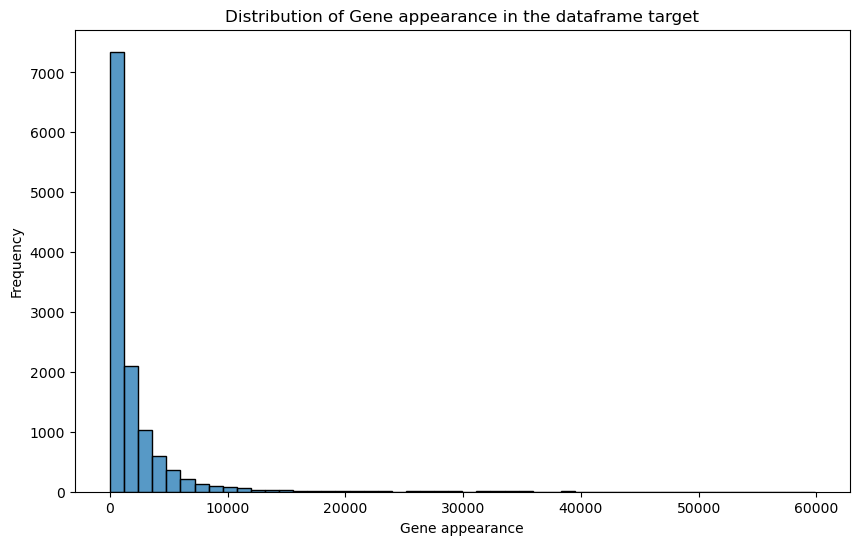

In [116]:
df1 = PP_data.layers["log1p_norm"]
# Convert sparse matrix to dense if necessary
if issparse(df1):
    df1 = df1.toarray()
c_sum=sum_col(df1)
print(c_sum)
print(max(c_sum))
print(min(c_sum))
distribution(c_sum, "Gene appearance", "target")

We observe that expression levels vary greatly depending on the gene, ranging from 18 to 60000 (log-transformed). Most genes have expression levels below 1500 (log-transformed). This is why normalization is crucial to mitigate the impact of outliers and extreme values. 

[ 566.45085668  433.91371381  210.46009441 ... 1475.97534949  176.56517991
 1920.37679691]
97060.78870384308
19.486305907918744


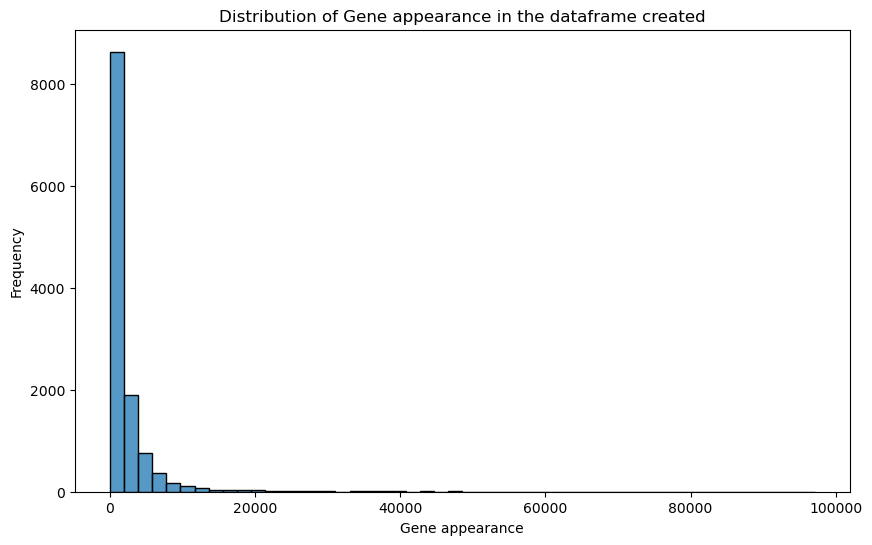

In [117]:
df2 = adata.layers["log1p_norm"]
# Convert sparse matrix to dense if necessary
if issparse(df2):
    df2 = df2.toarray()
c_sum=sum_col(df2)
print(c_sum)
print(max(c_sum))
print(min(c_sum))
distribution(c_sum, "Gene appearance", "created")

We observe that expression levels vary greatly depending on the gene, ranging from 19 to 97000 (log-transformed). Most genes have expression levels below 2000 (log-transformed). This is why normalization is crucial to mitigate the impact of outliers and extreme values. 

We can also observed that the targeted dataset has a gene appearance maximum value lower than the dataset I created and seems to have less genes with a high appearance. This is again certainly due to a stronger gene filter for the targeted dataset. 

## Distribution of read per sample

[1240.76702539 1250.7977848  1386.86078863 ... 3392.22222174 3299.559591
 3616.86023454]
3770.1641838669393
1144.919709859842


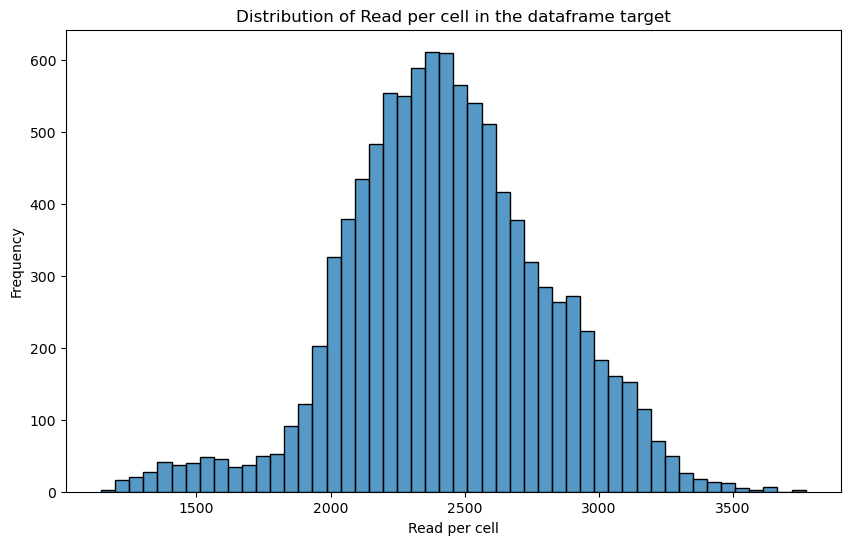

In [118]:
r_sum=sum_row(df1)
print(r_sum)
print(max(r_sum))
print(min(r_sum))
distribution(r_sum, "Read per cell", "target")

We observe that reads per cell levels vary greatly depending on the cell, ranging from 1144 to 3770 (log-transformed). The distribution looks overall normal.


[ 909.18001174  916.71009909  899.98846625 ... 1252.06974072 1502.47303723
 1265.54215086]
1752.5818282750624
540.3454286264545


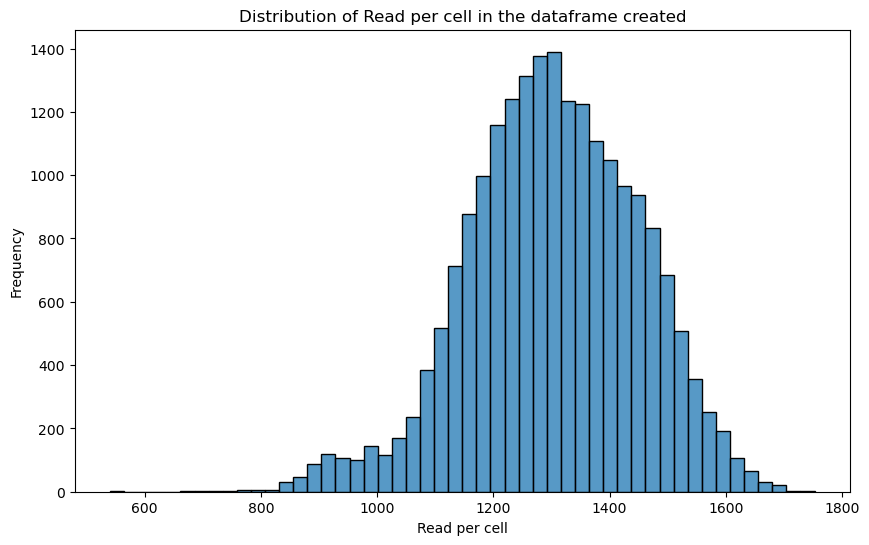

In [119]:
r_sum=sum_row(df2)
print(r_sum)
print(max(r_sum))
print(min(r_sum))
distribution(r_sum, "Read per cell", "created")

We observe that reads per cell levels vary greatly depending on the cell, ranging from 540 to 1752 (log-transformed). The distribution looks overall normal.

We can also observed that the targeted dataset has a read per cell maximum value higher than the dataset I created and seems to have more cells with a high read value. 

## Example of results

### Clustering

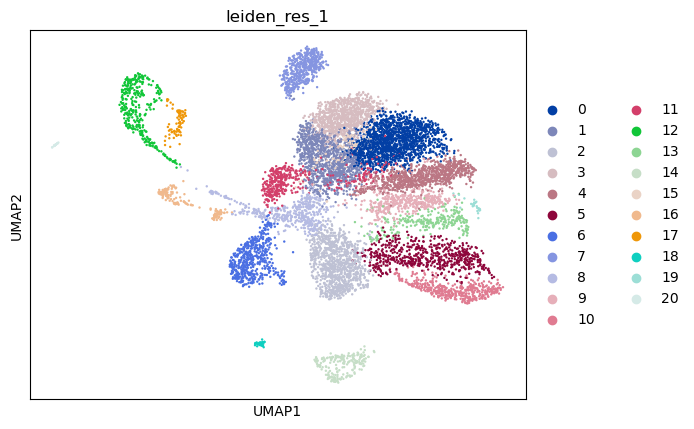

In [107]:
sc.pl.umap(PP_data, color=["leiden_res_1"])

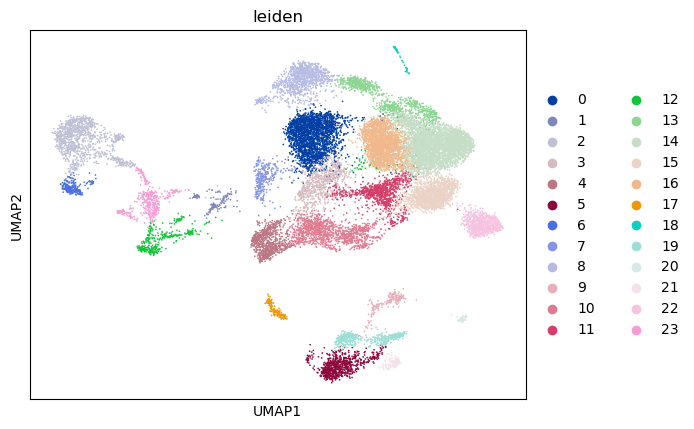

In [108]:
sc.pl.umap(adata, color=["leiden"])

On this clustering, we can see that results are not the same between the targeted dataset and the one I created. But overall the data seems to be distributed on the same places : on the top right there is the majority of the data, and on the top left and on the bottom right there is small cluster of data.

### PCA

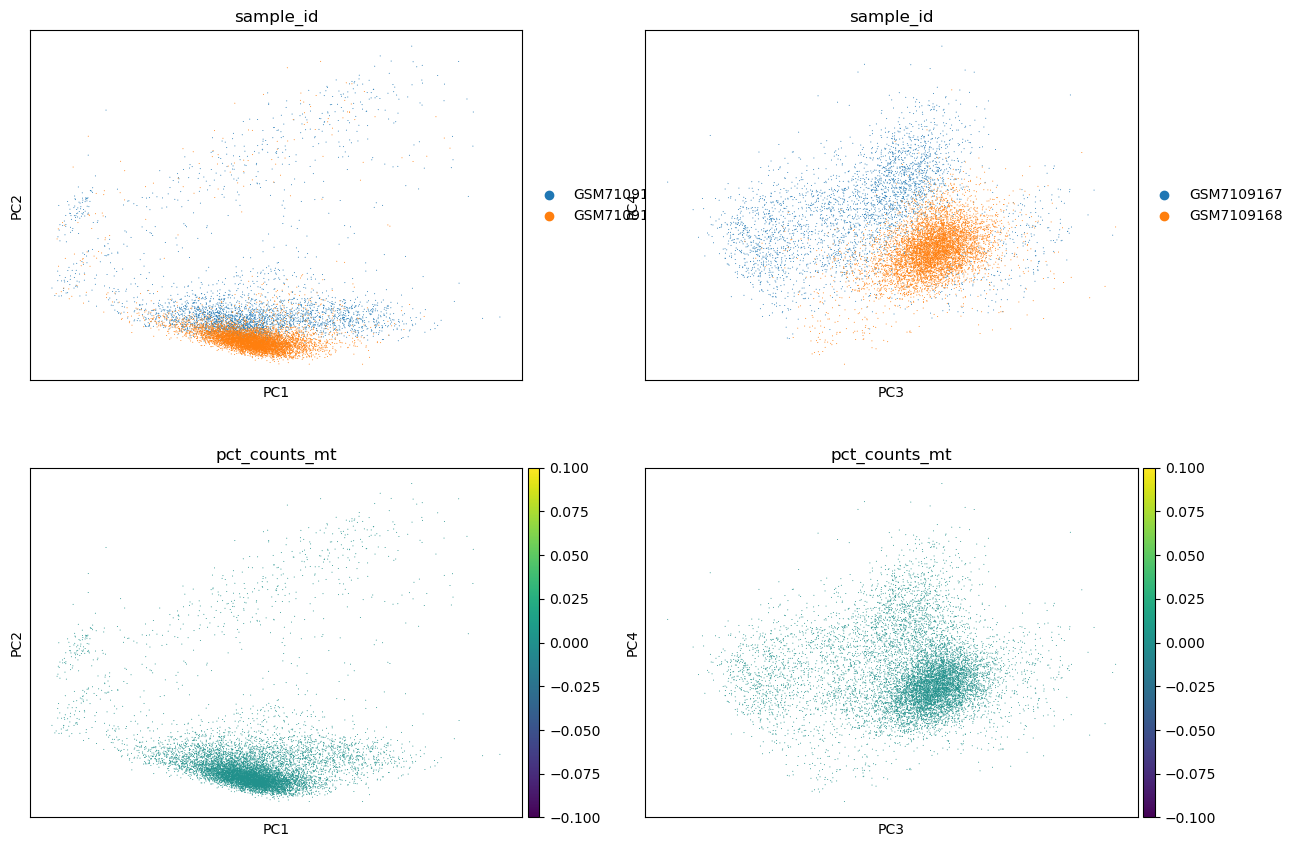

In [109]:
sc.pl.pca(
    PP_data,
    color=["sample_id", "sample_id", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

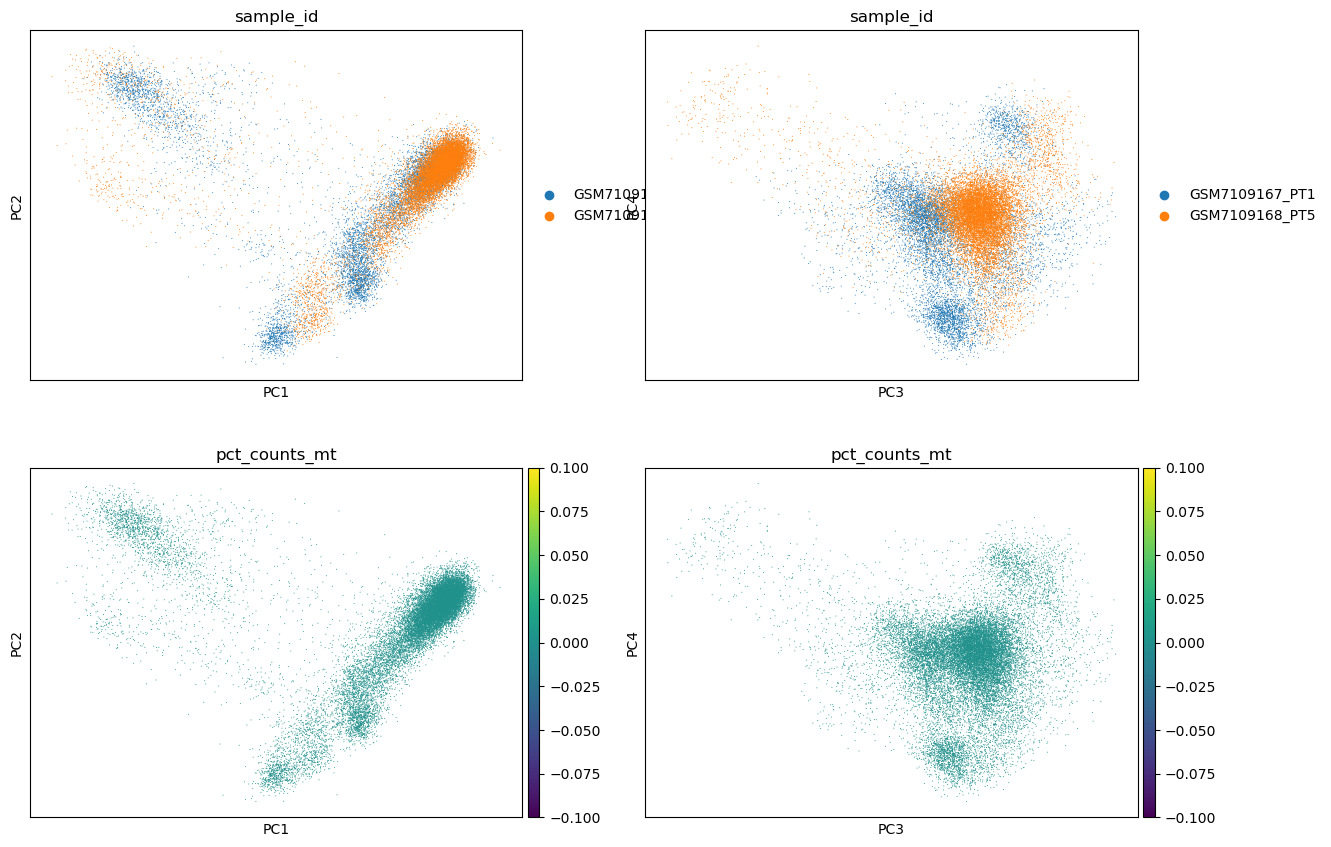

In [110]:
sc.pl.pca(
    adata,
    color=["sample_id", "sample_id", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

On this PCA, we can see that results are not the same between the targeted dataset and the one I created. But overall the data seems to be distributed in the same space (close between the two samples). We can also notice that on the dataset I produced, data from the two samples are more mixed and not separate as in the targeted dataset.